<a href="https://www.kaggle.com/code/aymaneid/sql-queries-and-data-vis-for-chicago-crime-data?scriptVersionId=113238117" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In this notebook we'll take a look at using SQL commands to access large data sets, together with some simple visualisation techniques for crime data. 

We'll first import some packages we'll need. In order to handle SQL queries we'll use `bq_helper`.

In [1]:
import pandas as pd
import numpy as np
import bq_helper
from bq_helper import BigQueryHelper

The code snippet below gives bq_helper the name of the dataset we're interested in, and loads just the first 3 rows to give us an idea of what it looks like.

In [2]:
chicago_crime = bq_helper.BigQueryHelper(active_project="bigquery-public-data",
                                   dataset_name="chicago_crime")
bq_assistant = BigQueryHelper("bigquery-public-data", "chicago_crime")
bq_assistant.head("crime", num_rows=3)

,unique_key,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location
0,20294,HV178038,2012-02-29 06:51:00+00:00,005XX E 104TH PL,0110,HOMICIDE,FIRST DEGREE MURDER,HOUSE,False,False,512,5,9,49,01A,1181956.0,1835794.0,2012,2022-08-31 04:51:30+00:00,41.704641,-87.609313,"(41.704641317, -87.609312999)"
1,24071,JB359746,2018-07-21 11:31:00+00:00,002XX W 106TH ST,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,False,False,512,5,34,49,01A,1176557.0,1834650.0,2018,2022-09-18 04:45:51+00:00,41.701625,-87.629118,"(41.701624878, -87.629117507)"
2,24878,JC558323,2019-12-23 11:01:00+00:00,007XX E 106TH ST,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,True,False,512,5,9,50,01A,1182956.0,1834823.0,2019,2022-09-18 04:45:51+00:00,41.701954,-87.605681,"(41.701953638, -87.60568122)"


If you're not interested in SQL, you can go ahead and load the whole dataset into memory as a pandas dataframe with the following: 

`myquery = """SELECT * FROM `bigquery-public-data.chicago_crime.crime`"""
data = chicago_crime.query_to_pandas(myquery)`

We're going to use SQL throughout however, as one of the goals of this notebook is to practice for much larger datasets where loading everything into memory isn't an option. 

One of the advantages of SQL is that you can be very precise about what data you want to query, and it's considered good practice to only query what you actually want. In order to do this, let's take a look at how the data is formatted:

In [3]:
bq_assistant.table_schema("crime")

,name,type,mode,description
0,unique_key,INTEGER,REQUIRED,None
1,case_number,STRING,NULLABLE,None
2,date,TIMESTAMP,NULLABLE,None
3,block,STRING,NULLABLE,None
4,iucr,STRING,NULLABLE,None
5,primary_type,STRING,NULLABLE,None
6,description,STRING,NULLABLE,None
7,location_description,STRING,NULLABLE,None
8,arrest,BOOLEAN,NULLABLE,None
9,domestic,BOOLEAN,NULLABLE,None


It's worth noting initially that several of the columns are redundant, e.g. there's no need to call the `year` column if we're calling the `date` column, and there's no need to call `latitude` or `longitude` if we're calling `location`. 

Let's start with a simple graph of how the rate for certain crimes has varied over the years. The following query will pull the year and type of each crime recorded, and count up how many records appear for each year and type. We create a table to display the data, ordered by year and then by the number of incidences of each crime, and then use `matplotlib` to plot it.

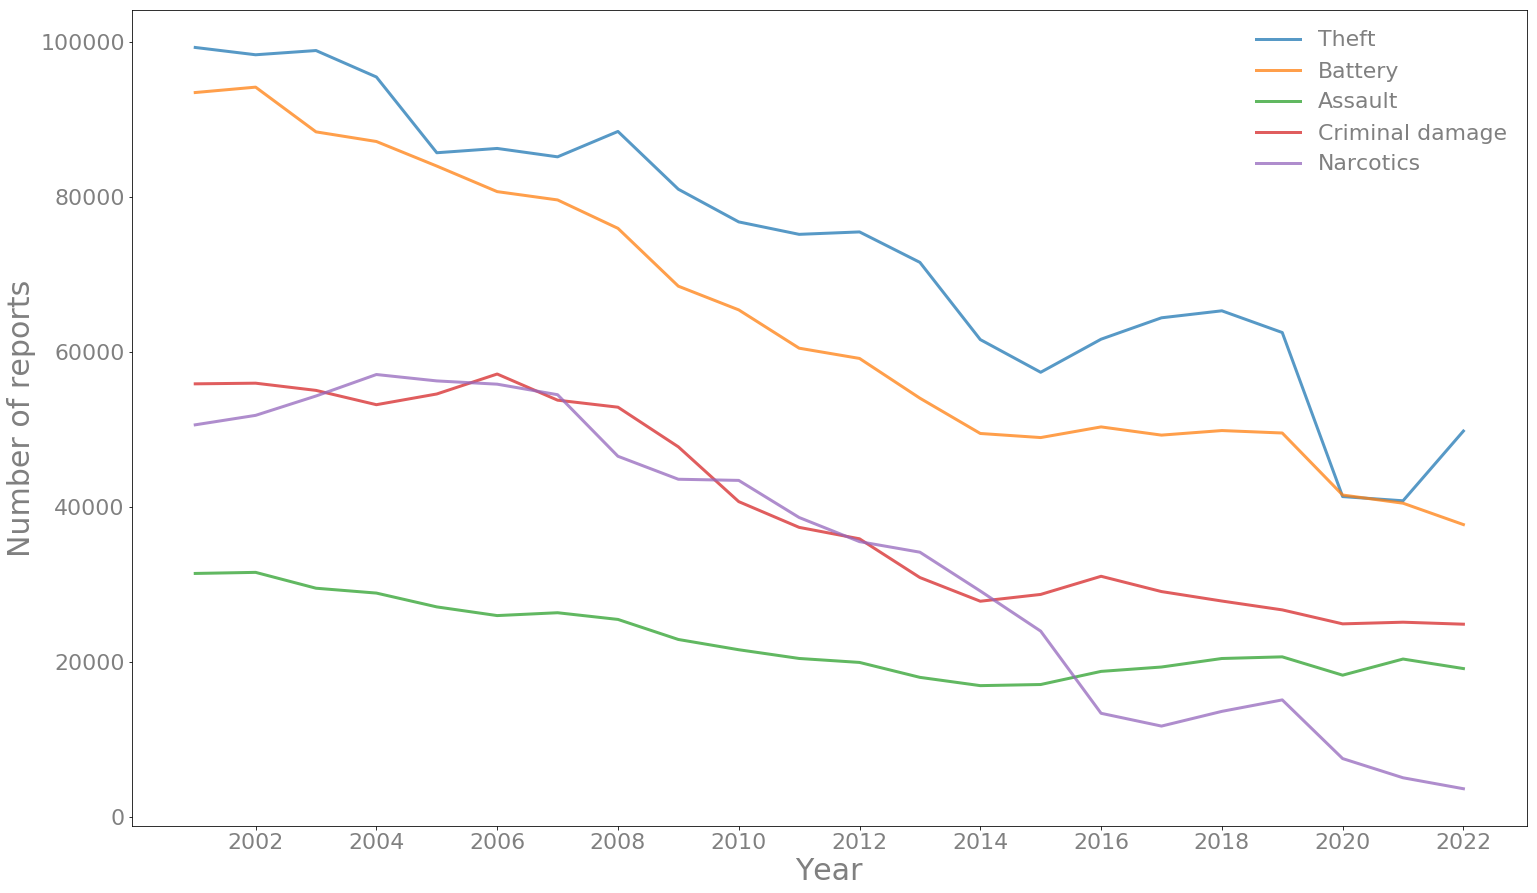

In [4]:
all_crime_query = """ SELECT year, primary_type, COUNT(*) as count
                        FROM `bigquery-public-data.chicago_crime.crime`
                        GROUP BY year, primary_type
                        ORDER BY year, count DESC
                        """

all_crime_data = chicago_crime.query_to_pandas_safe(all_crime_query)

import matplotlib.pyplot as plt 

plt.rcParams['font.size'] = 22 #set default text size
fig, ax = plt.subplots(1, 1, figsize=(25, 15)) 
#loop over the crimes of interest, plotting a line for each one:
for crime in ['THEFT', 'BATTERY', 'ASSAULT', 'CRIMINAL DAMAGE', 'NARCOTICS']:
    ax.plot(all_crime_data.loc[all_crime_data['primary_type'] == crime, ['year']], all_crime_data.loc[all_crime_data['primary_type'] == crime, ['count']], label=crime.lower().capitalize(), linewidth=3.0, alpha = 0.75)

plt.ylabel("Number of reports", size=30, color = 'grey')
plt.xlabel("Year", size=30, color = 'grey')

plt.xticks(np.arange(min(all_crime_data.year)+1, max(all_crime_data.year)+1, step=2), color = 'grey')
plt.yticks(np.arange(0, 110000, 20000), color='grey')
legend = plt.legend(loc=0, fontsize='medium', frameon=False)
plt.setp(legend.get_texts(), color='grey')
plt.show()

While there's a general downward trend among all five categories, what stands out most is the sudden downturn in 2018. This is because we only have partial data for 2018! In order to make a more accurate plot, we could simply not include the 2018 data. But we could also make a forecast about what to expect in 2018. 

One way of doing this is simply to scale up our 2018 figures according to how much of the year we don't have data for. But there's an implicit assumption here that the crime rate doesn't vary over the course of the year. So before we go with this option, let's check the data. The following query pulls records between 2011 and 2017, groups the number of crimes by month, and then plots the data, with a line for each crime of interest.

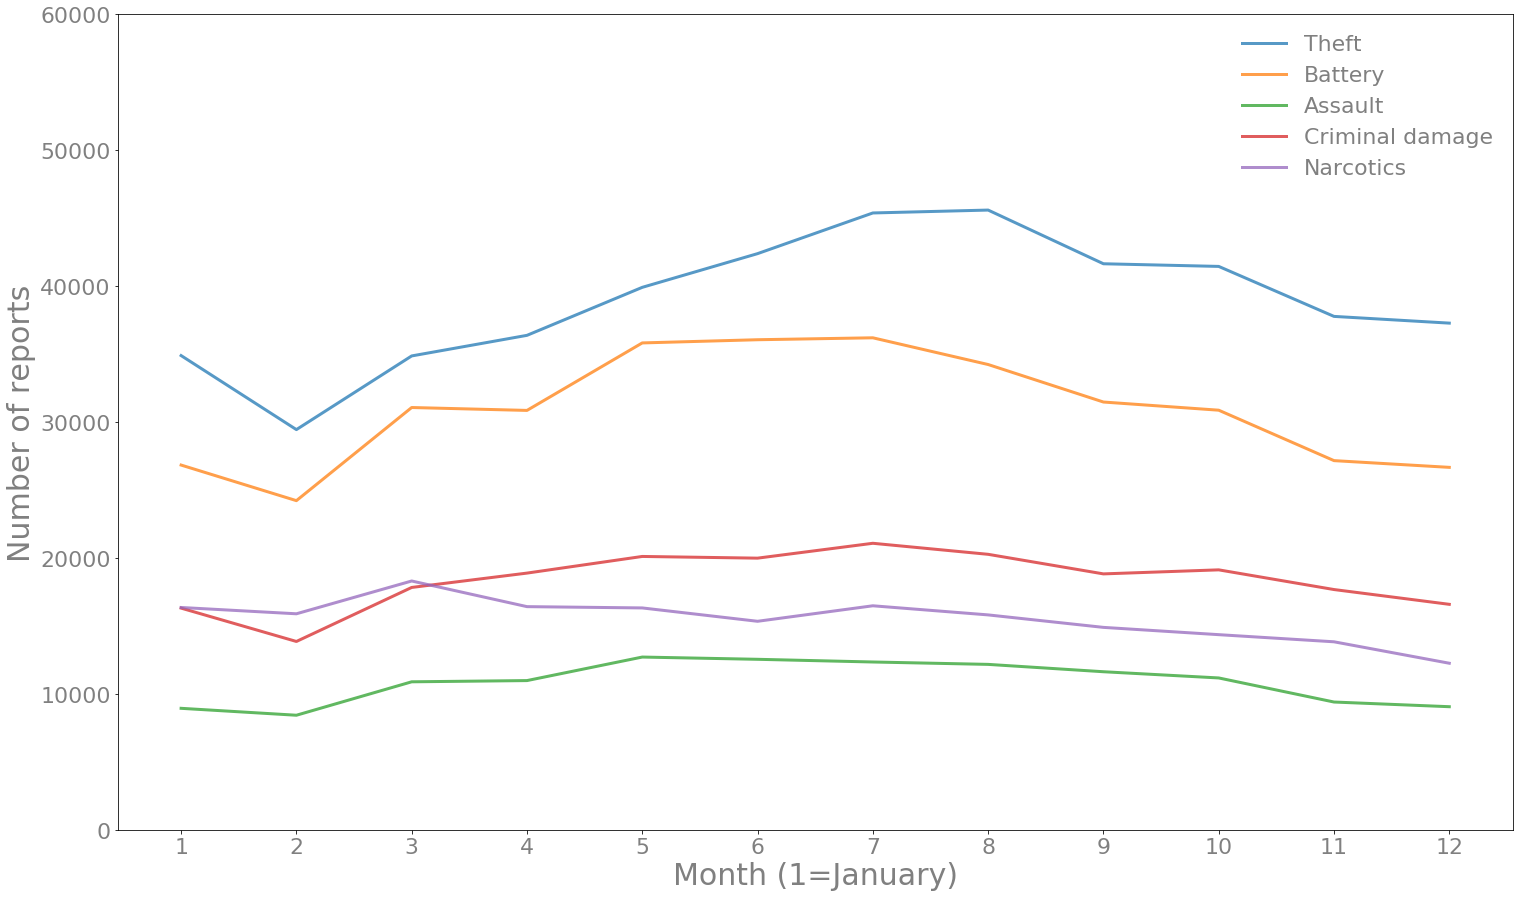

In [5]:
monthly_query = """ 
SELECT 
  primary_type,  EXTRACT(MONTH FROM date) AS Month, Count(*) as count
FROM
  `bigquery-public-data.chicago_crime.crime`
WHERE (year >2010) AND (year <2018)
GROUP BY  Month, primary_type
ORDER BY  Month, count DESC
                        """
monthly_data = chicago_crime.query_to_pandas_safe(monthly_query)

fig, ax = plt.subplots(1, 1, figsize=(25, 15))

for crime in ['THEFT', 'BATTERY', 'ASSAULT', 'CRIMINAL DAMAGE', 'NARCOTICS']:
    plt.plot(monthly_data.loc[monthly_data['primary_type'] == crime, ['Month']], monthly_data.loc[monthly_data['primary_type'] == crime, ['count']], label=crime.lower().capitalize(), linewidth=3.0, alpha=0.75)
plt.xticks(np.arange(1, 13, 1), color='grey')
plt.yticks(np.arange(0, 61000, 10000), color='grey')
plt.ylabel("Number of reports", color='grey', size = 30)
plt.xlabel("Month (1=January)", color='grey', size = 30)

legend = plt.legend(loc=1, fontsize='medium', frameon=False)
plt.setp(legend.get_texts(), color='grey')
plt.show()

It doesn't look like the narcotics or criminal damage categories vary much, but certainly the other three seem to increase over the summer months, so simply scaling up the data based on how much of the year is remaining is not a good idea. 

Instead, we'll compare the data for the first 8 months of 2017 with the data for the first 8 months of 2018. For each of the five crimes we're interesed in we can compute a ratio telling us how much the incidence of that crime has gone up or down so far in 2018, and use that to extrapolate from the 2017 data. We'll use a dashed line on our plot to indicate that the final data point is just a forecast of what to expect.

In the SQL query below, in order to make sure we're only taking the same chunk of records from 2017 as we have for 2018, we use the `UNIX_SECONDS` function to convert the date to seconds and require that more than a year lies between any record pulled from 2017 and the most recent record in 2018.

In [6]:
truncated_2017_query = """ SELECT year, primary_type, COUNT(*) as count
                        FROM `bigquery-public-data.chicago_crime.crime`
                        WHERE (UNIX_SECONDS((SELECT MAX(date)
                                      FROM `bigquery-public-data.chicago_crime.crime`)) - UNIX_SECONDS(date) > UNIX_SECONDS(TIMESTAMP "2018-01-01 00:00:00") - UNIX_SECONDS(TIMESTAMP "2017-01-01 00:00:00"))
                        AND (year = 2017)
                        GROUP BY year, primary_type
                        ORDER BY count DESC
                        """

truncated_2017_data = chicago_crime.query_to_pandas_safe(truncated_2017_query)
truncated_2018_data = all_crime_data.loc[all_crime_data['year'] == 2018, ['primary_type', 'count']]
full_2017_data = all_crime_data.loc[all_crime_data['year'] == 2017, ['primary_type', 'count']]
# extrapolate our 2017 numbers:
theft_forecast = full_2017_data.iloc[0][1]*(truncated_2018_data.iloc[0][1]/ truncated_2017_data.iloc[0][2])
battery_forecast = full_2017_data.iloc[1][1]*truncated_2018_data.iloc[1][1]/ truncated_2017_data.iloc[1][2]
criminal_damage_forecast = full_2017_data.iloc[2][1]*(truncated_2018_data.iloc[2][1] / truncated_2017_data.iloc[2][2])
assault_forecast = full_2017_data.iloc[3][1]*(truncated_2018_data.iloc[3][1] / truncated_2017_data.iloc[3][2])
narcotics_forecast = full_2017_data.iloc[8][1]*(truncated_2018_data.iloc[6][1] / truncated_2017_data.iloc[7][2])

up_to_2017_crime_data = all_crime_data.loc[all_crime_data['year'] != 2018, ['year', 'primary_type', 'count']]
interpolated_crime_data = all_crime_data.loc[all_crime_data['year'] == 2017, ['year', 'primary_type', 'count']]
# add on our forecasted data:
forecast = {'year':[2018, 2018, 2018, 2018, 2018], 'primary_type':["THEFT", "BATTERY", "CRIMINAL DAMAGE", "ASSAULT", "NARCOTICS"], 'count':[theft_forecast, battery_forecast, criminal_damage_forecast, assault_forecast, narcotics_forecast]}
forecast_data = pd.DataFrame(data = forecast)
interpolated_crime_data = interpolated_crime_data.append(forecast_data)

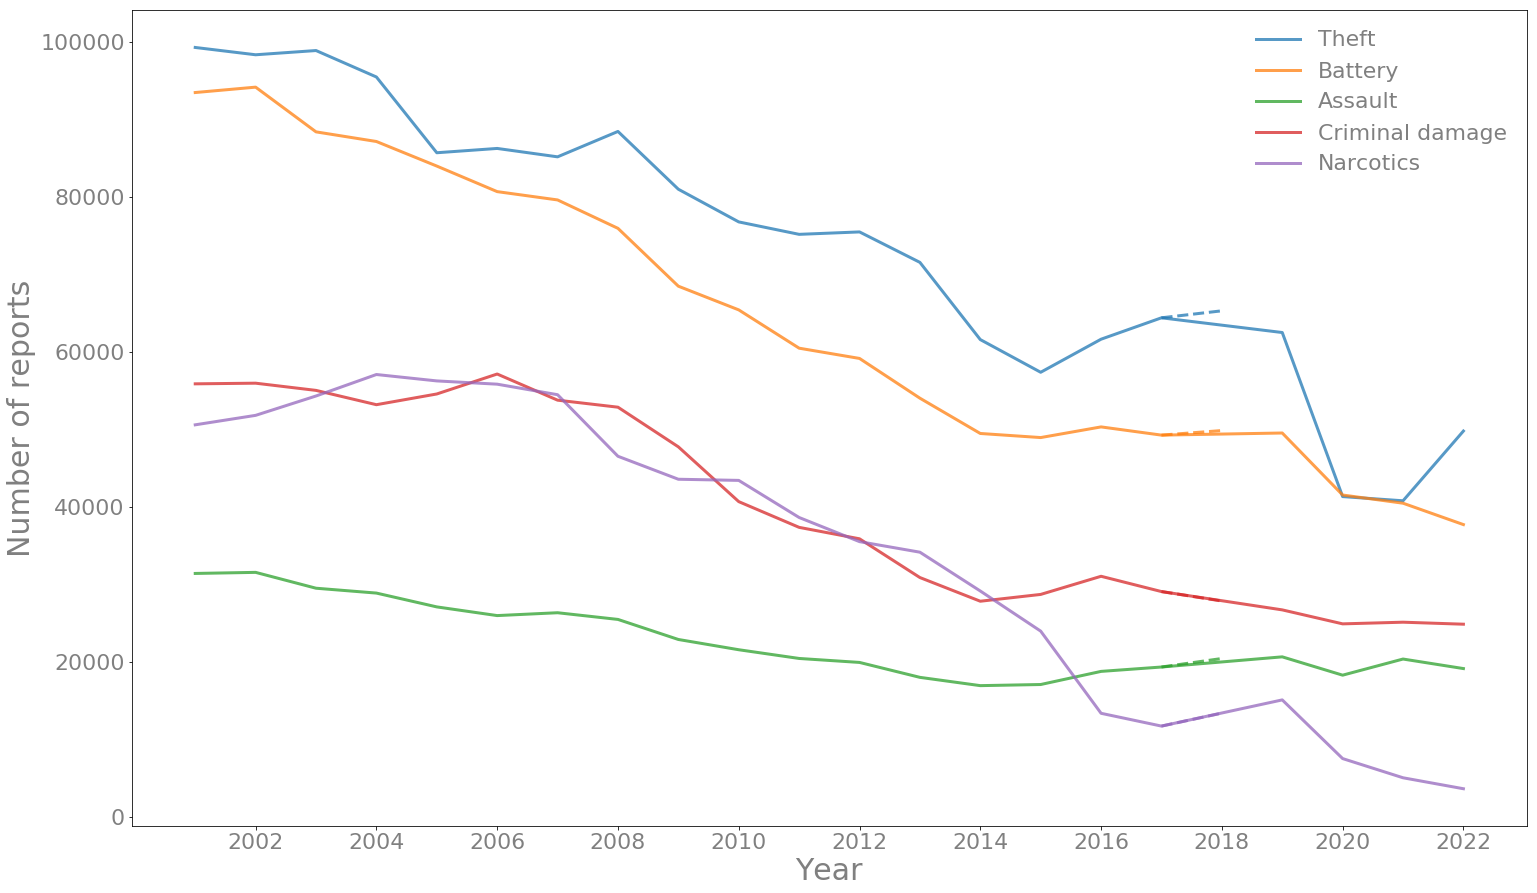

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(25, 15))

i=0
for crime in ['THEFT', 'BATTERY', 'ASSAULT', 'CRIMINAL DAMAGE', 'NARCOTICS']:
    ax.plot(up_to_2017_crime_data.loc[up_to_2017_crime_data['primary_type'] == crime, ['year']], up_to_2017_crime_data.loc[up_to_2017_crime_data['primary_type'] == crime, ['count']], label=crime.lower().capitalize(), linewidth=3.0, alpha = 0.75)
    ax.plot(interpolated_crime_data.loc[interpolated_crime_data['primary_type'] == crime, ['year']], interpolated_crime_data.loc[interpolated_crime_data['primary_type'] == crime, ['count']], '--', color='C'+str(i), linewidth=3.0, alpha = 0.75)
    i = i+1 # a counter to ensure our colours match on the interpolated plot
    
plt.xticks(np.arange(min(all_crime_data.year)+1, max(all_crime_data.year)+1, step=2), color='grey')
plt.yticks(np.arange(0, 110000, 20000), color='grey')
plt.ylabel("Number of reports", size = 30, color='grey')
plt.xlabel("Year", size = 30, color='grey')
legend = plt.legend(loc=1, fontsize='medium', frameon=False)
plt.setp(legend.get_texts(), color='grey')
plt.show()

While we've got a good global overview of the crime trends in Chicago, we can also study local trends within the data. Each crime report is associated with a particular ward of the Chicago police department, of which there are 50.

Despite the downward trend above, there seems to be an uptick in assault and theft between 2016 and 2017, and this seems to persist in our 2018 forecast. We'll focus on these two categories in more detail, to see if these increases are confined to particular wards or not. 

Below we create a scatter plot of the percentage change in assault and theft for each ward between 2016 and 2017. The size of each circle corresponds to the total number of assaults and thefts recorded in that ward. In order not to crowd the plot, we only label the points with unusually large increases/decreases in incidence. 

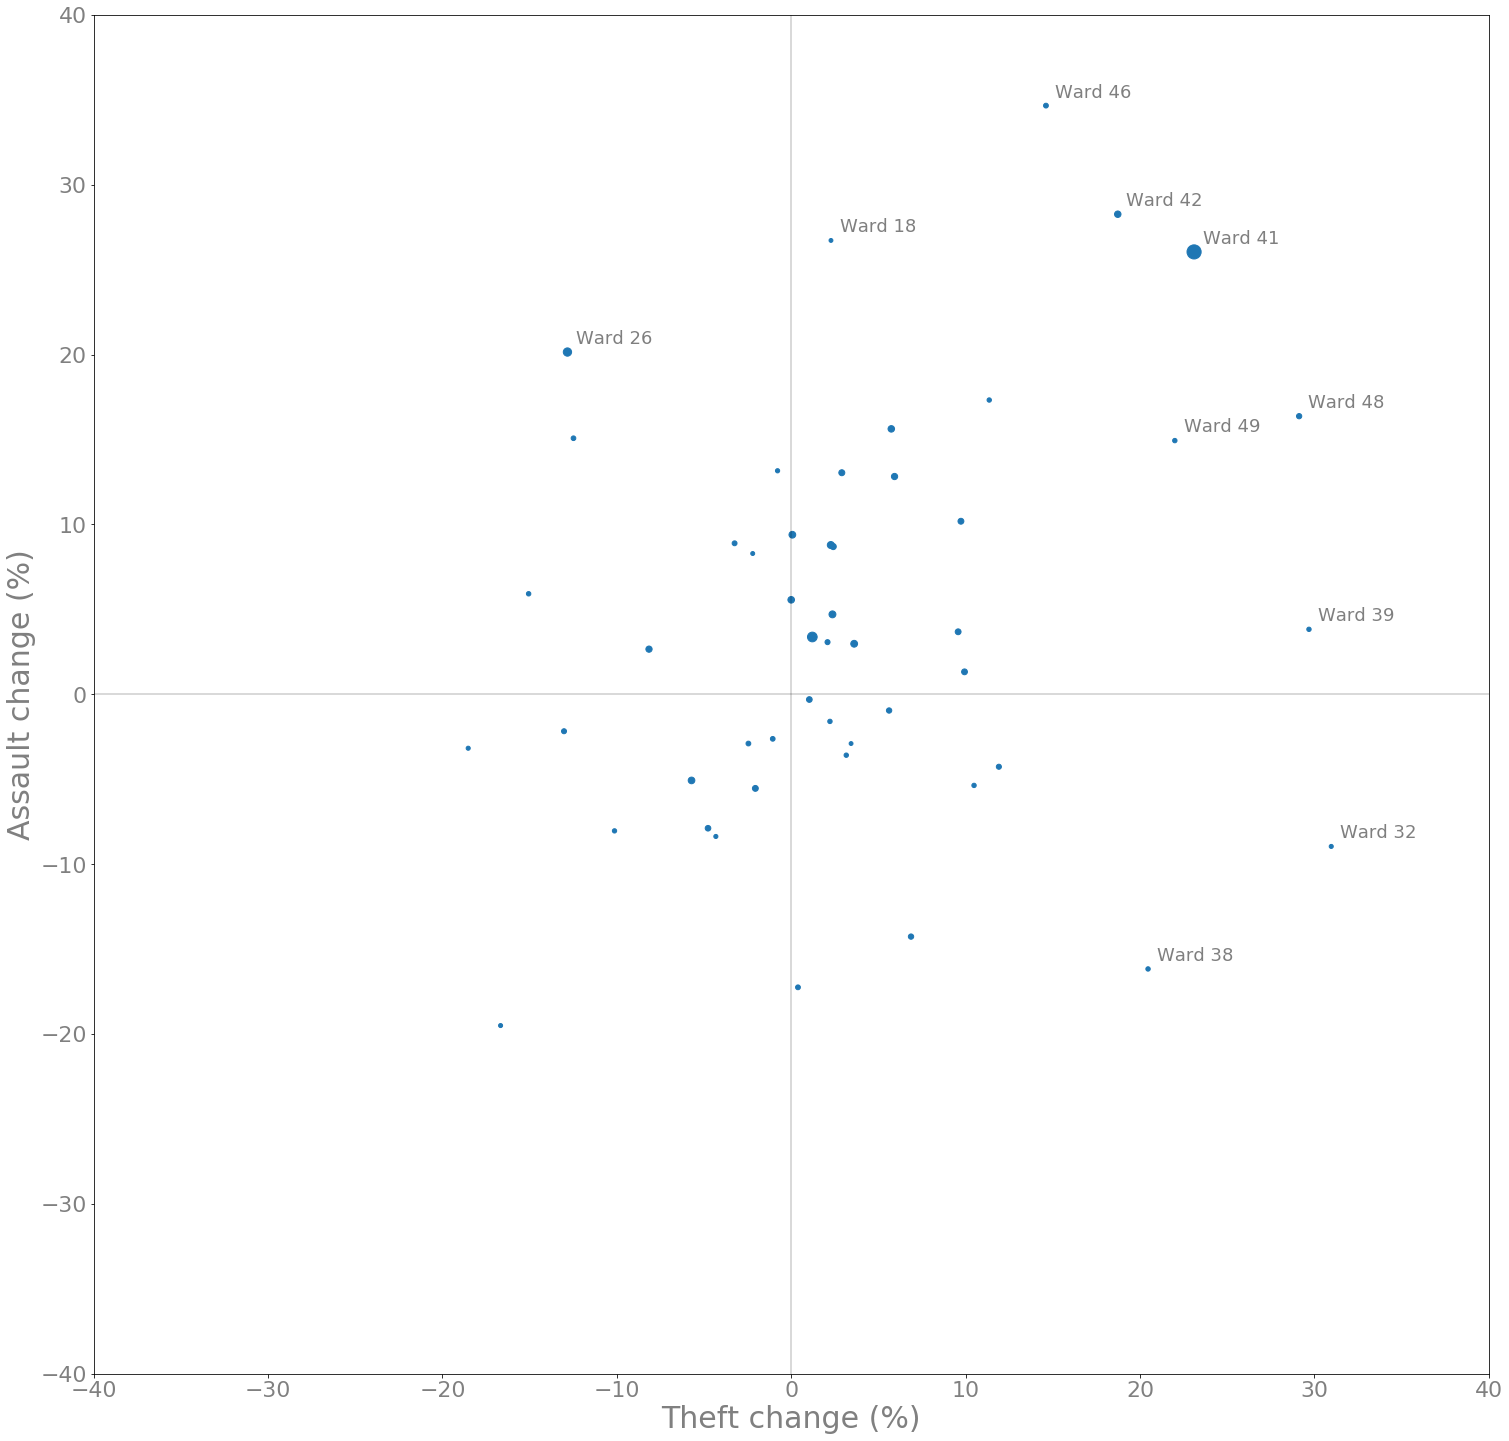

In [8]:
ward_query = """ SELECT year, primary_type, ward, COUNT(*) as count
                        FROM `bigquery-public-data.chicago_crime.crime`
                        WHERE (is_nan(ward) = FALSE) AND ((primary_type = 'ASSAULT') OR (primary_type = 'THEFT')) AND ((year = 2017) OR (year = 2016))
                        GROUP BY year, primary_type, ward
                        ORDER BY year, primary_type, ward
                        """
ward_data = chicago_crime.query_to_pandas_safe(ward_query)
# we could do the following with SQL queries instead, but usually best to do locally:
ward_assault = ward_data.loc[ward_data['primary_type'] == 'ASSAULT', ['year', 'ward', 'count']]
ward_assault_2017 = ward_assault.loc[ward_assault['year'] == 2017, ['ward', 'count']]
ward_assault_2016 = ward_assault.loc[ward_assault['year'] == 2016, ['ward', 'count']]
ward_theft = ward_data.loc[ward_data['primary_type'] == 'THEFT', ['year', 'ward', 'count']]
ward_theft_2017 = ward_theft.loc[ward_theft['year'] == 2017, ['ward', 'count']]
ward_theft_2016 = ward_theft.loc[ward_theft['year'] == 2016, ['ward', 'count']]

fig, ax = plt.subplots(1, 1, figsize=(25, 25))

myx = 100*(np.array(ward_theft_2017['count']) - np.array(ward_theft_2016['count']))/np.array(ward_theft_2016['count'])
myy = 100*(np.array(ward_assault_2017['count']) - np.array(ward_assault_2016['count']))/np.array(ward_assault_2016['count'])
plt.ylabel("Assault change (%)", color='grey', size=30)
plt.xlabel("Theft change (%)", color='grey', size=30)
# plot axes through the origin:
ax.axhline(y=0, color='k', alpha=0.2)
ax.axvline(x=0, color='k', alpha=0.2)

for i in range(50):
    if (abs(myx[i]) > 19) or (abs(myy[i]) > 20): # only plot 'unusual' wards
        ax.annotate("Ward " + str(i), (myx[i], myy[i]), alpha=0.5, xytext = (myx[i] + 0.5, myy[i] + 0.5), size = 18)
ax.scatter(myx, myy, s = 1/50*(np.array(ward_theft_2017['count']) + np.array(ward_assault_2017['count'])))
plt.xticks(np.arange(-40, 50, 10), color='grey')
plt.yticks(np.arange(-40, 50, 10), color='grey')
plt.show()

Our data also comes with precise geographic information, and the natural way to plot data with geographic information is on a map. 

We'll do this with the `bokeh` library, which allows us to pull map data from Google Maps and plot whatever we like on top in just one or two lines of code. Unfortunately kaggle does not allow notebooks to make web queries so this won't work in-browser, but I'll provide the code used below together with an image of the resulting plot. 

We'll take a look at where the most common places for narcotics violations were in 2017. Marking each location clearly on the map would cover the city. Instead we choose a low alpha-value for our marks so that the locations with the most narcotics violations are immediately clear.

In [9]:
narc_2017_query = """ SELECT latitude, longitude
                        FROM `bigquery-public-data.chicago_crime.crime`
                        WHERE (primary_type = 'NARCOTICS') AND (year = 2017)
                        """
narc_2017_data = chicago_crime.query_to_pandas_safe(narc_2017_query)

In [10]:
# from bokeh.io import output_file, show
# from bokeh.models import ColumnDataSource, GMapOptions
# from bokeh.plotting import gmap
# output_file("gmap.html")
# map_options = GMapOptions(lat=41.80, lng=-87.65, map_type="roadmap", zoom=11)
# d = gmap("You need to put your own API key here", map_options, title="Chicago Narcotics Violations")
# source = ColumnDataSource(
#     data=dict(mylat=lat,
#               mylon=long)
# )
# d.circle(x="mylon", y="mylat", size=7, fill_color="red", fill_alpha=0.05, line_alpha=0, source=source)
# show(d)


![https://image.ibb.co/gCh1aK/thiry.png](https://image.ibb.co/gCh1aK/thiry.png) 

There's a huge amount more to explore inside the Chicago Crime dataset, the purpose of this notebook is just to give a few examples together with some sample code for various SQL queries and various plots. 